<center><h1><span style='color:#FF7133'><u>Creating COCO-Style Annotations from Images and Masks</u></span></h1></center>

Images used for training the algorithm are composed of the image itself and a corresponding mask that was created to label the fish in the image. The image and mask are two separate files. If there are multiple instances of fish in an image, each instance will have its own mask for identification and segmentation. This script defines the annotations and labeled regions (created from the mask images) so they can be called from the COCO-style dictionaries or COCO API.

Import main libraries:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import os

%matplotlib inline

<br>

Image files and their mask files have the exact same name but are saved in two separate directories. Some images may not have masks, so it is important to identify images that have masks.

In [2]:
img_dir = Path('/home/tamer/UChiMSCA/MSCA37011_DeepLearningImgRec/Project/fish_img')  #adjust to appropriate location
msk_dir = Path('/home/tamer/UChiMSCA/MSCA37011_DeepLearningImgRec/Project/fish_mask')  #adjust to appropriate location

In [3]:
fishImg = os.listdir(img_dir)
fishMask = os.listdir(msk_dir)

images = [im for im in (fishImg and fishMask)]

Select an image at random to test the script and se how it works:

In [4]:
imgFile = np.random.choice(images)
img, mask = (Image.open(str(i) + '/' + imgFile) for i in (img_dir, msk_dir))
img, mask = img.convert('RGB'), mask.convert('RGB')

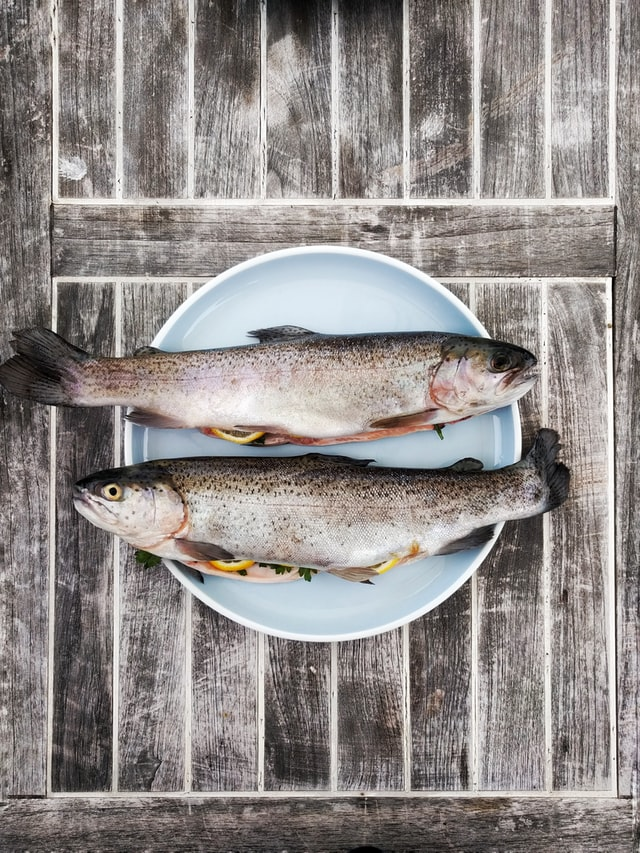

In [5]:
# View the original image
img

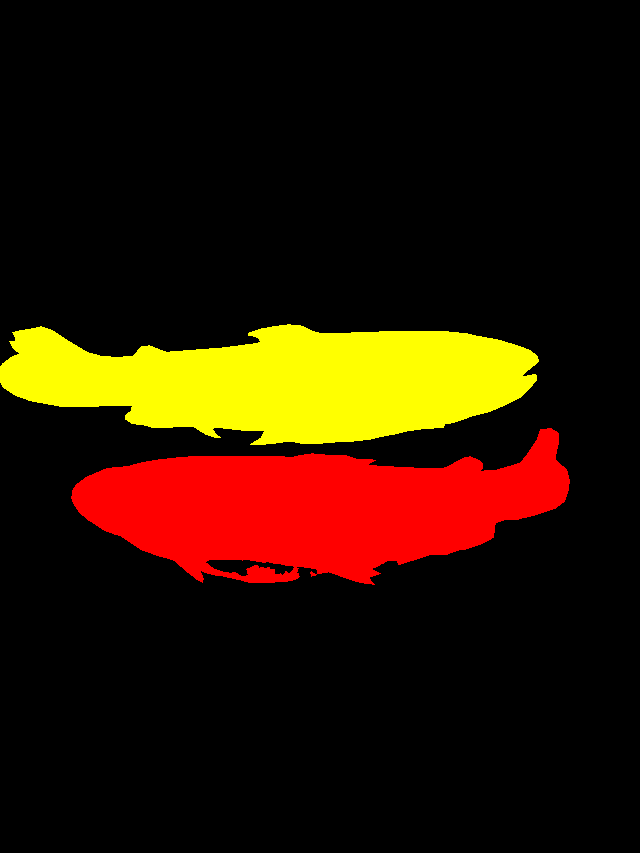

In [6]:
# View its labeling mask
mask

<br>

Object instances (in this case, instances of fish) in the same image are identified by a unique mask color for each instance. Most original images only have one instance but some have multiple instances. To separate the instances in an image, the color coordinates of the mask are used as a dictionary key with a PIL image object of the mask pixels as its value. The PIL image object can be used to extract contours using functions from Scikit-Image.

In [7]:
from itertools import product
w, h = mask.size  # width, height of mask
coords = list(product(range(w), range(h)))  # x,y pixel coordinates
isolated_masks = dict()
for coord in coords:
    # make a key for every color (i.e every instance)
    pixelRGB = mask.getpixel(coord)
    pixelRGB_str = str(mask.getpixel(coord))
    # create a new binary image for each new instance, add its pixels
    if not pixelRGB == (0,0,0):
        if isolated_masks.get(pixelRGB_str) is None:
            isolated_masks[pixelRGB_str] = Image.new('1', (w+2, h+2))  # pad the edges

        isolated_masks[pixelRGB_str].putpixel((coord[0]+1, coord[1]+1), 1)

In [8]:
# Find the contours
from skimage.measure import find_contours
objs = dict()
for key, msk in isolated_masks.items():
    contours = find_contours(msk, 0.5, positive_orientation='low')
    objs[key] = contours

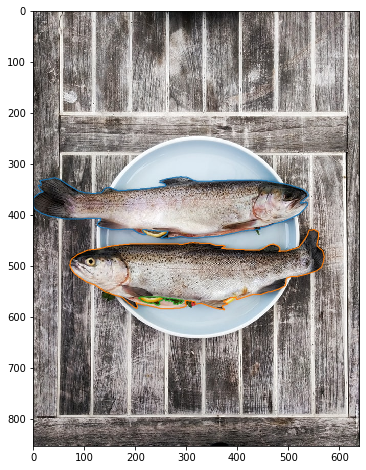

In [9]:
# Plot the contours as a check
fig, ax = plt.subplots(figsize=(12,8))
plt.imshow(img)
for contour in objs.values():
    for i in range(len(contour)):
        ax.plot(contour[i][:, 1], contour[i][:, 0], linewidth=1)

Note that the contour will be off slightly in the above plot because of the added 1px padding. This will be adjusted later.